<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/1b_retropropagacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retropropagación

En este *notebook* programaremos con NumPy una red neuronal densa y la entrenaremos en problemas de clasificación no lineal usando del gradiente descedente con el algoritmo de retropropagación.

In [1]:
import numpy as np

## Activación, pérdida y métricas
Nuestra red neuronal densa está compuesta por una capa de 2 entradas ($x_1$ y $x_2$), una capa oculta con 10 neuronas con función de activación sigmoide y una capa de salida con una sola neurona con función de activación sigmoide. Esta función de activación se define como:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [2]:
def sigmoide(z):
  return 1 / (1 + np.exp(-z))

La función sigmoide tiene una derivada que está expresada en términos de la misma función, esto es,

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [3]:
def derivada_sigmoide(x):
  s = sigmoide(x)
  return s * (1.0 - s)

Podemos ver la operación XOR como una tarea de clasificación binaria a partir de 2 entradas. Por lo tanto, usaremos la función de pérdida de entropía cruzada binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [4]:
def entropia_cruzada_binaria(y, p):
  p[p == 0] = np.nextafter(0., 1.)
  p[p == 1] = np.nextafter(1., 0.)
  return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

Asimismo, calcularemos la exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa:

$$
exactitud = \frac{correctos}{total}
$$

In [5]:
def exactitud(y, y_predicha):
  return (y == y_predicha).mean() * 100

Ahora, definimos la función que propaga hacia adelante una entrada $\mathbf{X} \in \mathbb{R}^{m \times d}$. Como la red está compuesta de 2 capas densas (1 oculta y 1 de salida), tenemos 2 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}} \in \mathbb{R}^{d \times l}, \mathbf{b}^{\{1\}} \in \mathbb{R}^{l \times 1}\}$ y $\{\mathbf{W}^{\{2\}} \in \mathbb{R}^{l \times k}, \mathbf{b}^{\{2\}} \in \mathbb{R}^{k \times 1}\}$ de la capa oculta y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$$
	\begin{split}
				\mathbf{A}^{\{1\}} & =  \mathbf{X} \\
				\mathbf{Z}^{\{2\}} & =  \mathbf{A}^{\{1\}} \cdot \mathbf{W}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{A}^{\{2\}} & =  \sigma(\mathbf{Z}^{\{2\}}) \\
				\mathbf{Z}^{\{3\}} & =  \mathbf{A}^{\{2\}} \mathbf{W}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{A}^{\{3\}} & =  \sigma(\mathbf{Z}^{\{3\}})\\
				\mathbf{\hat{y}} & =  \mathbf{A}^{\{3\}}
		\end{split}
  $$

In [6]:
def hacia_adelante(X, W1, b1, W2, b2):
  Z2 = X @ W1 + b1
  A2 = sigmoide(Z2)
  Z3 = A2 @ W2 + b2
  y_hat = sigmoide(Z3)
  return Z2, A2, Z3, y_hat

Para facilitar el entrenamiento definimos una función que ordene aleatoriamente y vaya generando lotes del conjunto completo.

In [7]:
def genera_lotes(X, y, t_lote=16):
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  perm = np.random.permutation(X.shape[0]) # se genera una permutación aleatoria
  Xperm = X[perm] # se reordenan las entradas y
  yperm = y[perm] # las entradas usando la permutación
  for lote in range(n_lotes): # se van tomando t_lote entradas y salidas
    Xlote = Xperm[lote * t_lote:(lote + 1) * t_lote]
    ylote = yperm[lote * t_lote:(lote + 1) * t_lote]
    yield Xlote, ylote

## Descenso por gradiente mediante retropropagación de errores
Finalmente, definimos la función para entrenar nuestra red neuronal usando descenso por gradiente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación. Para nuestro caso, serían las siguientes expresiones:

$$
	\begin{split}
				\boldsymbol{\delta}^{\{3\}} & =  \mathbf{\hat{y}}^{(i)} - \mathbf{y}^{(i)}\\
				\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{2\}}} & =  \mathbf{A}^{\{2\}\top} \cdot \boldsymbol{\delta}^{\{3\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{2\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{3\}}_{j, :}\\
        \boldsymbol{\delta}^{\{2\}} & =  (\boldsymbol{\delta}^{\{3\}}\cdot \mathbf{W}^{\{2\}\top}) \odot \frac{\partial \mathbf{A}^{\{2\}}}{\partial \mathbf{Z}^{\{2\}}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{1\}}} & =  \sum_{j=1}^{l}\boldsymbol{\delta}^{\{2\}}_{j, :}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{1\}}} & =  \mathbf{A}^{\{1\}\top} \cdot \boldsymbol{\delta}^{\{2\}}\\
		\end{split}
  $$



In [8]:
from math import floor

def retropropagacion(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
  b2 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))
  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, y_hat = hacia_adelante(Xlote, W1, b1, W2, b2)

      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ3 = y_hat - ylote
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      dZ2 = (dZ3 @ W2.T) * derivada_sigmoide(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W2 -= alpha * dW2
      b2 -= alpha * db2
      W1 -= alpha * dW1
      b1 -= alpha * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, perdidas, exactitudes

## Inicializando los pesos con zeros
Como se mencionó anteriormente, las matrices de pesos $\mathbf{W^{\{1\}}}$ y $\mathbf{W^{\{2\}}}$ se initializan con valores aleatorios pequeños mientras que los vectores de sesgo $\mathbf{b^{\{1\}}}$ y $\mathbf{b^{\{1\}}}$ con zeros. Examinemos qué pasa si inicializamos las matrices de pesos con zeros. Observa los valores de los pesos en cada época.

In [9]:
def retropropagacion_zeros(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  W1 = np.zeros((n_entradas, n_ocultas))
  b1 = np.zeros((1, n_ocultas))

  W2 = np.zeros((n_ocultas, 1))
  b2 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))
  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      print(W1, b1, W2, b2)
      Z2, A2, Z3, y_hat = hacia_adelante(Xlote, W1, b1, W2, b2)

      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ3 = y_hat - ylote
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      dZ2 = (dZ3 @ W2.T) * derivada_sigmoide(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W2 -= alpha * dW2
      b2 -= alpha * db2
      W1 -= alpha * dW1
      b1 -= alpha * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, perdidas, exactitudes

## Evaluación con XOR
Para probar nuestra red, generamos los ejemplos correspondientes a la operación XOR.

In [10]:
# ejemplo (XOR)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

Finalmente, entrenamos nuestra red con estos ejemplos por 500 épocas usando una tasa de aprendizaje $\alpha = 0.5$.

In [11]:
np.random.seed(42)
W1, b1, W2, b2, perdidas, exactitudes = retropropagacion(X,
                                                         y,
                                                         alpha = 0.5,
                                                         n_epocas = 500,
                                                         n_ocultas = 10,
                                                         t_lote=1)

Epoch 0: Pérdida = 0.9563221640394213 Exactitud = 25.0
Epoch 1: Pérdida = 0.9442934576740258 Exactitud = 50.0
Epoch 2: Pérdida = 0.987762619572907 Exactitud = 0.0
Epoch 3: Pérdida = 0.9889740382616683 Exactitud = 25.0
Epoch 4: Pérdida = 0.9476586374403205 Exactitud = 50.0
Epoch 5: Pérdida = 0.9480759201240736 Exactitud = 25.0
Epoch 6: Pérdida = 0.9096548664507809 Exactitud = 25.0
Epoch 7: Pérdida = 0.8232071496222566 Exactitud = 50.0
Epoch 8: Pérdida = 0.957128441796392 Exactitud = 25.0
Epoch 9: Pérdida = 0.9020352684453864 Exactitud = 50.0
Epoch 10: Pérdida = 0.9012094850317537 Exactitud = 25.0
Epoch 11: Pérdida = 0.8376010967560599 Exactitud = 75.0
Epoch 12: Pérdida = 0.932432688331088 Exactitud = 25.0
Epoch 13: Pérdida = 0.8313099555350836 Exactitud = 25.0
Epoch 14: Pérdida = 0.8886704428590736 Exactitud = 50.0
Epoch 15: Pérdida = 0.8715210317558876 Exactitud = 25.0
Epoch 16: Pérdida = 0.8110403807283011 Exactitud = 50.0
Epoch 17: Pérdida = 0.9182003101571496 Exactitud = 0.0
Epoch 1

Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

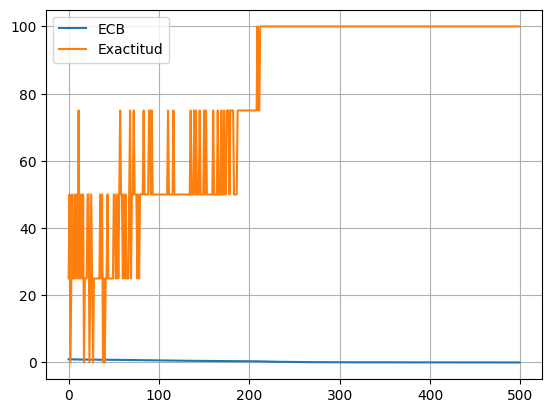

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

¿Qué pasa si inicializamos los pesos con ceros.

In [13]:
np.random.seed(42)
W1, b1, W2, b2, perdidas, exactitudes = retropropagacion_zeros(X,
                                                               y,
                                                               alpha = 0.5,
                                                               n_epocas = 500,
                                                               n_ocultas = 10,
                                                               t_lote=1)

Se han truncado las últimas 5000 líneas del flujo de salida.
 [-2.36069145 -2.36069145 -2.36069145 -2.36069145 -2.36069145 -2.36069145
  -2.36069145 -2.36069145 -2.36069145 -2.36069145]] [[-1.29380279 -1.29380279 -1.29380279 -1.29380279 -1.29380279 -1.29380279
  -1.29380279 -1.29380279 -1.29380279 -1.29380279]] [[-1.37705775]
 [-1.37705775]
 [-1.37705775]
 [-1.37705775]
 [-1.37705775]
 [-1.37705775]
 [-1.37705775]
 [-1.37705775]
 [-1.37705775]
 [-1.37705775]] [[0.76929351]]
[[-2.37701528 -2.37701528 -2.37701528 -2.37701528 -2.37701528 -2.37701528
  -2.37701528 -2.37701528 -2.37701528 -2.37701528]
 [-2.36739572 -2.36739572 -2.36739572 -2.36739572 -2.36739572 -2.36739572
  -2.36739572 -2.36739572 -2.36739572 -2.36739572]] [[-1.30050706 -1.30050706 -1.30050706 -1.30050706 -1.30050706 -1.30050706
  -1.30050706 -1.30050706 -1.30050706 -1.30050706]] [[-1.37206323]
 [-1.37206323]
 [-1.37206323]
 [-1.37206323]
 [-1.37206323]
 [-1.37206323]
 [-1.37206323]
 [-1.37206323]
 [-1.37206323]
 [-1.3720

## Clasificación no lineal
Ahora vamos a probar las funciones en un problema de clasificación no lineal usando un conjunto de datos sintético.

In [14]:
np.random.seed(42)
Xreal = np.random.randn(1000, 2)
yreal = np.logical_xor(Xreal[:, 0] > 0, Xreal[:, 1] > 0)

Dividimos el conjunto de datos generado.

In [15]:
from sklearn.model_selection import train_test_split

Xent, Xval, yent, yval = train_test_split(Xreal, yreal, test_size=0.2, random_state=42)

Definimos una función para graficar el conjunto de datos:

In [16]:
from sklearn.model_selection import train_test_split

def grafica_datos(modelo, X_ent, y_ent, X_val, y_val, frontera=None):
  fig, ax = plt.subplots()
  ax.scatter(X_ent[:, 0], X_ent[:, 1], c=y_ent, cmap=plt.cm.coolwarm,
             s=30, edgecolors='k', label='Validación')
  ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.coolwarm,
             s=30, alpha=0.5, edgecolors='k', label='Validación')

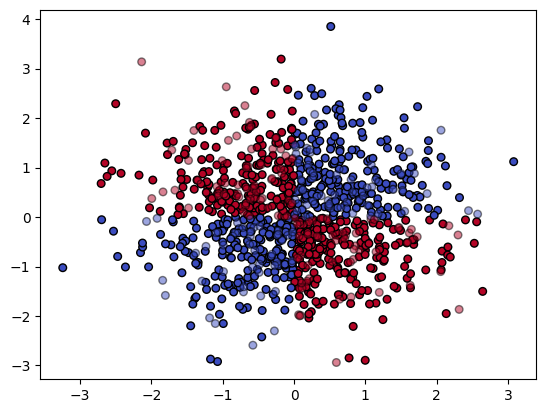

In [17]:
grafica_datos(_, Xent, yent, Xval, yval, frontera=False)

Finalmente, entrenamos nuestra red con estos ejemplos por 500 épocas usando una tasa de aprendizaje $\alpha = 0.5$.

In [18]:
np.random.seed(0)
W1, b1, W2, b2, perdidas, exactitudes = retropropagacion(Xent,
                                                         yent[:, np.newaxis],
                                                         alpha = 0.1,
                                                         t_lote=16,
                                                         n_epocas = 500,
                                                         n_ocultas = 10)

Epoch 0: Pérdida = 11.87852405610738 Exactitud = 52.0
Epoch 1: Pérdida = 11.276761998386919 Exactitud = 54.125
Epoch 2: Pérdida = 9.55181850977195 Exactitud = 68.5
Epoch 3: Pérdida = 8.07982220591342 Exactitud = 76.25
Epoch 4: Pérdida = 6.38820383661709 Exactitud = 84.0
Epoch 5: Pérdida = 5.04276714865999 Exactitud = 88.0
Epoch 6: Pérdida = 4.312469765504627 Exactitud = 90.375
Epoch 7: Pérdida = 3.7318754054975924 Exactitud = 91.625
Epoch 8: Pérdida = 3.364363760769119 Exactitud = 94.125
Epoch 9: Pérdida = 3.2436842276737106 Exactitud = 93.75
Epoch 10: Pérdida = 3.079947262203331 Exactitud = 93.0
Epoch 11: Pérdida = 2.852738324906406 Exactitud = 93.5
Epoch 12: Pérdida = 2.783323946179684 Exactitud = 94.5
Epoch 13: Pérdida = 2.6531313470677986 Exactitud = 95.25
Epoch 14: Pérdida = 2.5630069180383 Exactitud = 95.5
Epoch 15: Pérdida = 2.565541755119251 Exactitud = 94.625
Epoch 16: Pérdida = 2.5073733591912775 Exactitud = 94.625
Epoch 17: Pérdida = 2.337804788357212 Exactitud = 96.0
Epoch 

Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

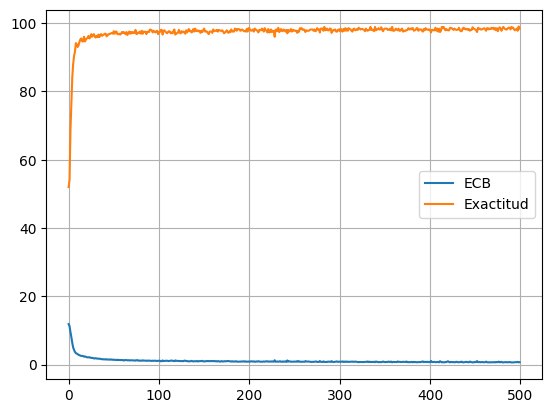

In [19]:
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

Evalúamos el desempeño del modelo en el conjunto de validación:

In [20]:
_, _, _, y_hat = hacia_adelante(Xval, W1, b1, W2, b2)
print(exactitud(yval[:, np.newaxis], np.round(y_hat).astype(bool)))

95.5
